In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import os
import sys
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from collections import deque
import random
import seaborn as sns
sns.set()
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('dataset/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400


In [3]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

novelty_search_threshold = 6
novelty_log_maxlen = 1000
backlog_maxsize = 500
novelty_log_add_amount = 3

In [4]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.last_features = None
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [5]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.generation_backlog = []
        self.novel_backlog = []
        self.novel_pop = []
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def _memorize(self, q, i, limit):
        q.append(i)
        if len(q) > limit:
            q.pop()
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual,date1,close):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(close) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(close[t])
                initial_money -= close[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, close[t], initial_money))
                
                df1 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]],'RESULT': ['Buy'] })
                if not os.path.isfile('output/22.neuro-evolution-novelty-search-agent.csv'):
                    df1.to_csv('output/22.neuro-evolution-novelty-search-agent.csv', index=False)
                else:
                    df1.to_csv('output/22.neuro-evolution-novelty-search-agent.csv', index=False, mode='a', header=False)
                    
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += close[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
                df2 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]],'RESULT': ['Sell'] })
                if not os.path.isfile('output/22.neuro-evolution-novelty-search-agent.csv'):
                    df2.to_csv('output/22.neuro-evolution-novelty-search-agent.csv', index=False)
                else:
                    df2.to_csv('output/22.neuro-evolution-novelty-search-agent.csv', index=False, mode='a', header=False)
            else:
                print(
                    'day %d, hold UNIT at price %f,  total balance %f,'
                    % (t+1, close[t+1], initial_money)
                )
                df3 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]], 'RESULT': ['Hold']})
                if not os.path.isfile('output/22.neuro-evolution-novelty-search-agent.csv'):
                    df3.to_csv('output/22.neuro-evolution-novelty-search-agent.csv', index=False)
                else:
                    df3.to_csv('output/22.neuro-evolution-novelty-search-agent.csv', index=False, mode='a', header=False)
            
            state = next_state
            
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
            self.population[i].last_features = self.population[i].W2.flatten()
    
    def evaluate(self, individual, backlog, pop, k = 4):
        score = 0
        if len(backlog):
            x = np.array(backlog)
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(backlog))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        if len(pop):
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(pop))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        return score
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            scores = [self.evaluate(p.last_features, self.novel_backlog, self.novel_pop) for p in self.population]
            sort_fitness = np.argsort(scores)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            
            for p in next_population:
                if p.last_features is not None:
                    self._memorize(self.novel_pop, p.last_features, backlog_maxsize)
                    if np.random.randint(0,10) < novelty_search_threshold:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
            
            if np.random.randint(0,10) < novelty_search_threshold:
                pop_sorted = sorted(self.population, key=lambda p: p.fitness, reverse=True)
                self.generation_backlog.append(pop_sorted[0])
                print('novel add fittest, score: %f, backlog size: %d'%(pop_sorted[0].fitness, 
                                                                        len(self.generation_backlog)))
                generation_backlog_temp = self.generation_backlog
                if len(self.generation_backlog) > backlog_maxsize:
                    generation_backlog_temp = random.sample(generation_backlog, backlog_maxsize)
                for p in generation_backlog_temp:
                    if p.last_features is not None:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
        return fittest_individual

In [6]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [7]:
fittest_nets = neural_evolve.evolve(1)

novel add fittest, score: 37.027929, backlog size: 1


In [8]:
date = df.Date.values.tolist()
neural_evolve.buy(fittest_nets,date1=date,close=close)

day 17: buy 1 unit at price 232.432434, total balance 9767.567566
day 20, sell 1 unit at price 238.308304, investment 2.527991 %, total balance 10005.875870,
day 51: buy 1 unit at price 308.558563, total balance 9697.317307
day 54, sell 1 unit at price 309.599609, investment 0.337390 %, total balance 10006.916916,
day 64: buy 1 unit at price 308.903900, total balance 9698.013016
day 65, sell 1 unit at price 301.946960, investment -2.252137 %, total balance 9999.959976,
day 67: buy 1 unit at price 292.152161, total balance 9707.807815
day 69, sell 1 unit at price 298.578583, investment 2.199683 %, total balance 10006.386398,
day 79: buy 1 unit at price 286.786774, total balance 9719.599624
day 82, sell 1 unit at price 295.565552, investment 3.061082 %, total balance 10015.165176,
day 118: buy 1 unit at price 300.480469, total balance 9714.684707
day 120, sell 1 unit at price 306.306305, investment 1.938840 %, total balance 10020.991012,
day 124: buy 1 unit at price 309.499512, total bal

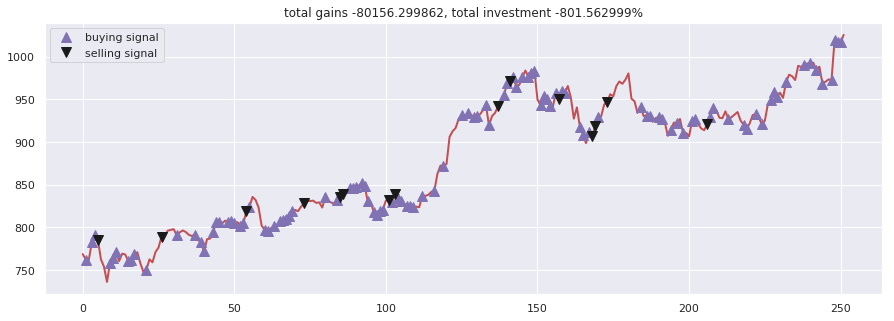

In [13]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()